# Plot numerically computed matern correlation lengths compared to theory

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

import cmocean
import warnings

In [2]:
fig_dir = '../figures'
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [3]:
plt.style.use('./correlation.mplstyle')

In [4]:
horizontal_factor = 1
n_ranges = [5, 10, 15, 20]
log10tol = -3
n_samples = 1000
corrs = []
for n_range in n_ranges:
    corrs2 = []
    for n_applications in [1, 2, 4, 8]:
        fname = f"/scratch2/tsmith/generic-matern-covariance/sampling/llc90/zstores/matern-corr-{n_applications:02d}apps/log10tol{log10tol:03d}.{n_range:02d}dx.{horizontal_factor:02}xi.{n_samples}samples"
        corrs2.append(xr.open_zarr(fname))
    corrs.append(xr.concat(corrs2, dim='n_applications'))
    
cds = xr.concat(corrs, dim='n_range')

In [5]:
cds.nbytes / 1e9

8.931088248

In [6]:
cds.load();

## Comparison to theory

In [8]:
k = 25
ix = 90
iy = 165

In [48]:
def plot_correlation(xds, dim, dsel, ax):
    
    adims = tuple(d for d in ('ix','iy','k') if d != dim)
    
    aspec = ax.get_subplotspec()
    theory_label = r'$r\,(||\hat{x}_1-\hat{x}_2||; \hat{\rho}, M)$'
    theory_label = theory_label if aspec.is_first_col() and xds.n_range==5 else None
    exp_label=r'$\hat{\rho}$ = %d' % n_range if aspec.is_first_col() else None
    
    # for simplicity, just showing positive, but it's the same either way...
    condition = xds['shifty'] >= 0
    if dim == 'k':
        condition = condition & (xds.rho_hat<25)
        
    x = xds['rho_hat'].where(condition)
    theory = xds[f'ideal_corr'].where(condition)
    yavg = xds[f"corr_{dim}"].where(condition).mean(adims)
    ystd = xds[f"corr_{dim}"].where(condition).std(adims)
    spread = xds[f"corr_{dim}"].where(condition).quantile([.1, .9], dim=adims)
    
    p = ax.plot(x, theory, label=theory_label, color='black')
    ax.fill_between(x,
                    spread.isel(quantile=0),
                    spread.isel(quantile=-1),
                    alpha=.3,
                    label=exp_label)

    if dim[-1] == 'x':
        lbl = 'i'
    elif dim[-1] == 'y':
        lbl = 'j'
    elif dim[-1] == 'k':
        lbl = 'k'
    else:
        raise ValueError("Unexpected dimension for label")
    ax.axhline(y=0.14, color='gray', alpha=.2)
    ax.set(xlabel=r'$\delta{%s}$' % lbl,ylabel='',title='')

In [52]:
def big_corr_plot(xds, dim, dsel):
    
    ncols = 4
    nrows = 1
    
    fig,axs = plt.subplots(nrows,ncols,figsize=(18,5*nrows),
                           sharey=True,
                           sharex=True)
    
    for n_applications, ax in zip(xds.n_applications.values, axs):
        for n_range in xds.n_range.values:
            plotme = xds.sel({dim:dsel, "n_range":n_range, "n_applications":n_applications}).squeeze()
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                plot_correlation(plotme, dim, dsel, ax)
                
        ax.text(25,.9, r"$M = %d$" % n_applications,
                ha='center',
               #bbox={'facecolor':'none', 'edgecolor':'gray', 'boxstyle':'round'}),
               )
            
            
    axs[0].set_ylabel('Correlation')
    [ax.set(xlim=[None, 40], xticks=np.arange(0,41,10)) for ax in axs]
    
    fig.subplots_adjust(wspace=.075)
    fig.legend(ncol=5,
               loc='center',
               bbox_to_anchor=(.5,-0.075),
               frameon=False)
    axs[-1].legend(loc='center left', bbox_to_anchor=(1., .5))
    return fig, axs

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


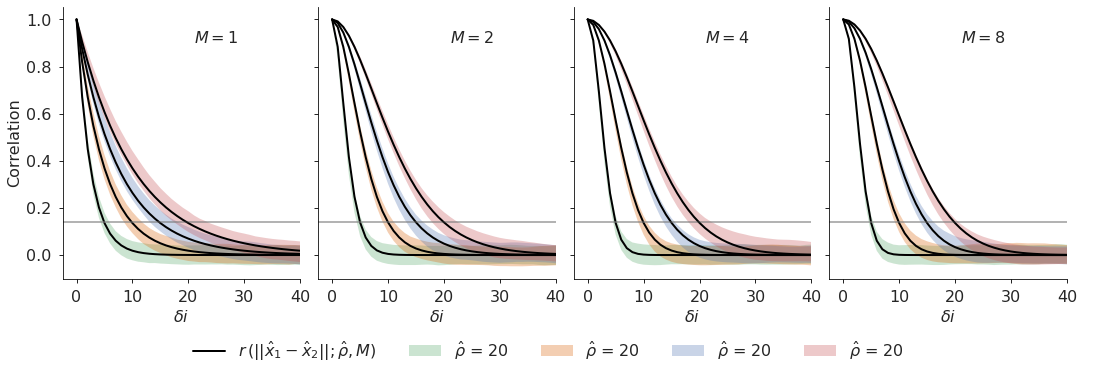

In [53]:
fig, axs = big_corr_plot(cds, 'ix', ix)
fig.savefig(f'{fig_dir}/matern_llc90_correlation_theory_vs_m_ix.pdf', bbox_inches='tight')

### Other dimensions

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


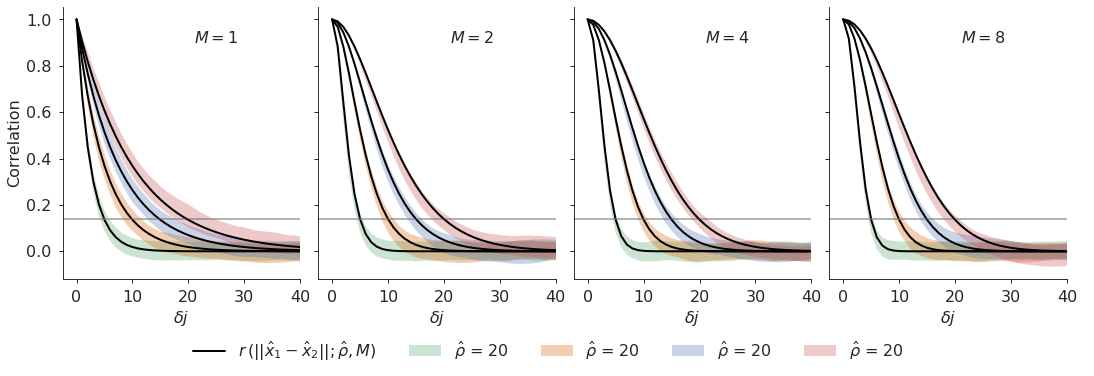

In [56]:
fig, axs = big_corr_plot(cds, 'iy', iy)
fig.savefig(f'{fig_dir}/matern_llc90_correlation_theory_vs_m_iy.pdf', bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


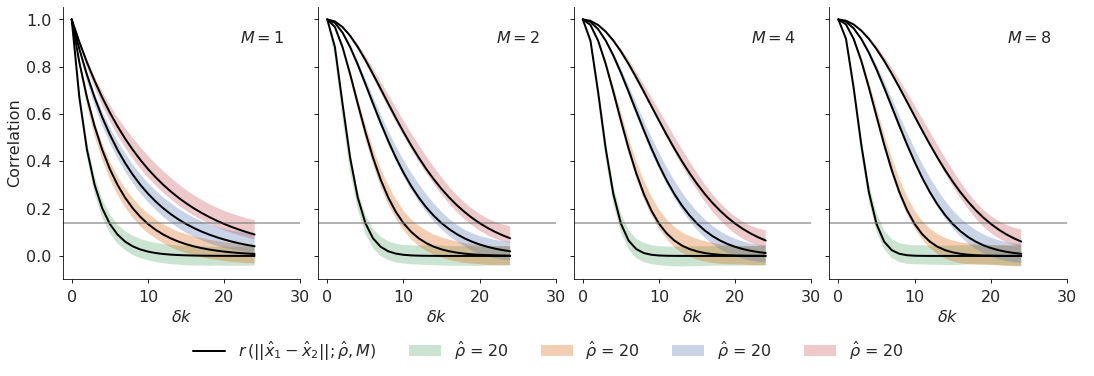

In [57]:
fig, axs = big_corr_plot(cds, 'k', kk)
[ax.set(xlim=[None,30]) for ax in axs];
fig.savefig(f'{fig_dir}/matern_llc90_correlation_theory_vs_m_k.pdf', bbox_inches='tight')